# INFO
- experiment: p300 speller
- stimulation: rsvp 100ms(stim) / 75ms(blank) / 2500ms break between char / 15 flashes per char / random words of 10 chars
- users tested: 1
- devices tested : 
    - muse 2: freq 256Hz / channels TP9,AF7,AF8,TP10
    - muse 2+: freq 256Hz / channels TP9,AF7,AF8,TP10,POz
    - OpenBCI: freq 125Hz / channels FC3,FCz,FC4,T7,C3,Cz,C4,T8,P7,P3,Pz,P4,P8,O1,O2,Oz
- metric used : Area Under the Curve (AUC)


This code demonstrates how to deduce a best fit classifier and word length for a given user and related dataset, for a given rsvp oddball p300 speller, by progressively decreasing the length of the dataset and comparing classifier with AUC.

# DEPENDENCIES

In [1]:
# BUILT-IN
import os,sys
import math
from collections import OrderedDict
import itertools
# DATAFRAMES
import pandas as pd
import numpy as np
# PLOTTING
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# MNE
from mne import Epochs, find_events
from mne.channels import read_montage
from mne import create_info, concatenate_raws
from mne.io import RawArray
from mne.decoding import Vectorizer
# SCIKIT-LEARN
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
# PYRIEMANN
from pyriemann.estimation import ERPCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM
from pyriemann.spatialfilters import Xdawn

# SETTINGS

In [2]:
the_folder_path = "../data/p300_speller" # relative datasets path
the_user = "compmonks" # "all" # check available users in data folder or add new ones
the_device = "muse2+" # "muse2+" # "muse2" # "openbci_v207" # available devices
the_freq = 256 # 256 (Muse) # 125 (OpenBCI) # Sampling Frequency in Hertz
the_montage = "standard_1005" # "standard_1005" (Muse) # "standard_1020" (OpenBCI) # channels montage
the_units = "uVolts" # "uVolts" # "Volts" # unit of received data from device
the_markers = {'Non-Target': 2, 'Target': 1} # markers from stim data
sns.set_context('talk')
sns.set_style('white')
diverging_color_palette = "coolwarm"
categorical_color_palette = "Paired"
char_num = 10 # number of total characters in the word
# if adding more users and data, please the data structure is adequate

# list of best known discriminators for P300
clfs = OrderedDict()
clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['Xdawn + RegLDA'] = make_pipeline(Xdawn(2, classes=[1]), Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['ERPCov + TS'] = make_pipeline(ERPCovariances(), TangentSpace(), LogisticRegression())
clfs['ERPCov + MDM'] = make_pipeline(ERPCovariances(), MDM())

# UTILS

In [3]:
def plotConditions(the_epochs, unit, channels_num, diff_waveform ,conditions = OrderedDict()):
    """ Plot ERP conditions. """

    confidence_interval = 97.5 # confidence interval in range [0, 100]
    bootstrap_samples = 1000 # number of bootstrap samples
    title = 'ERP Conditions'
    ylim = (-6,6) #(tuple): (ymin, ymax)
    if isinstance(conditions, dict):
        conditions = OrderedDict(conditions)
        palette = sns.color_palette(diverging_color_palette, len(conditions))
        if unit == "Volts":
            X = the_epochs.get_data() 
        elif unit == "uVolts":
            X = the_epochs.get_data() * 1e6 # convert from Volts to uVolts
        else:
            raise
        times = the_epochs.times
        y = pd.Series(the_epochs.events[:, -1])
        # get the amount of rows and columns and set axes
        fig_cell = math.ceil(math.sqrt(channels_num))
        fig, axes = plt.subplots(fig_cell, fig_cell, figsize=[12, 6],sharex=True, sharey=True)
        axes = [axes[row, col] for row in range(fig_cell) for col in range(fig_cell)]
        # make the subplots
        for ch in range(channels_num):
            for cond, color in zip(conditions.values(), palette):
                sns.tsplot(X[y.isin(cond), ch],
                           time = times, 
                           color = color,
                           n_boot = bootstrap_samples, 
                           ci = confidence_interval, 
                           ax = axes[ch])
            if diff_waveform:
                diff = (np.nanmean(X[y == diff_waveform[1], ch], axis=0) - np.nanmean(X[y == diff_waveform[0], ch], axis=0))
                axes[ch].plot(times, diff, color='darkblue', lw=0.25)
            axes[ch].set_title(the_epochs.ch_names[ch])
            axes[ch].set_ylim(ylim)
            axes[ch].axvline(x=0, ymin=ylim[0], ymax=ylim[1], color='grey',lw=0.5, label='_nolegend_')
        axes[0].set_ylabel('Amplitude (uV)')
        axes[-1].set_xlabel('Time (s)')
        if diff_waveform:
            legend = (['{} - {}'.format(diff_waveform[1], diff_waveform[0])] + list(conditions.keys()))
        else:
            legend = conditions.keys()
        axes[-1].legend(legend,loc='best',fontsize='xx-small')
        sns.despine()
        #plt.tight_layout()
        if title:
            fig.suptitle(title, fontsize=20)
        plt.show()
    else:
        print("bad conditions")

In [4]:
def segmentByLengthSeq(the_list,the_val,the_min_len):
    """Return an index of beginning of specific consecutive value sequences."""
    
    out = []
    i=0
    ind_=0
    for key,group in itertools.groupby(the_list):
        ind_ = len(list(group))
        if key == the_val and ind_>=the_min_len:
            out.append((key,ind_,i))
        i+=ind_
        
    return out

# POSTPROCESS & EVALUATE DISCRIMINATORS

training with 10 characters
device:muse2+ user:compmonks dir:session_000


c:\users\pierr\python354\lib\site-packages\pandas\core\indexes\base.py:2820: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  target = np.asarray(target)


Creating RawArray with float64 data, n_channels=6, n_times=96833
    Range : 0 ... 96832 =      0.000 ...   378.250 secs
Ready.
device:muse2+ user:compmonks dir:session_001
Creating RawArray with float64 data, n_channels=6, n_times=96887
    Range : 0 ... 96886 =      0.000 ...   378.461 secs
Ready.
device:muse2+ user:compmonks dir:session_002
Creating RawArray with float64 data, n_channels=6, n_times=96841
    Range : 0 ... 96840 =      0.000 ...   378.281 secs
Ready.
device:muse2+ user:compmonks dir:session_003
Creating RawArray with float64 data, n_channels=6, n_times=96829
    Range : 0 ... 96828 =      0.000 ...   378.234 secs
Ready.
device:muse2+ user:compmonks dir:session_004
Creating RawArray with float64 data, n_channels=6, n_times=96478
    Range : 0 ... 96477 =      0.000 ...   376.863 secs
Ready.
Effective window size : 8.000 (s)


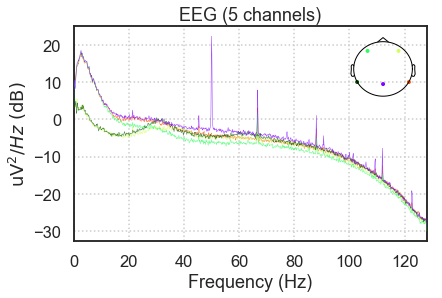

Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Effective window size : 8.000 (s)


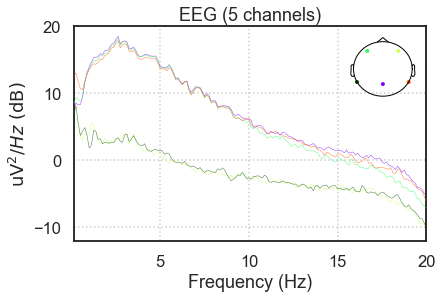

8979 events found
Event IDs: [1 2]
sample drop: 6.370419868582244 %


c:\users\pierr\python354\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


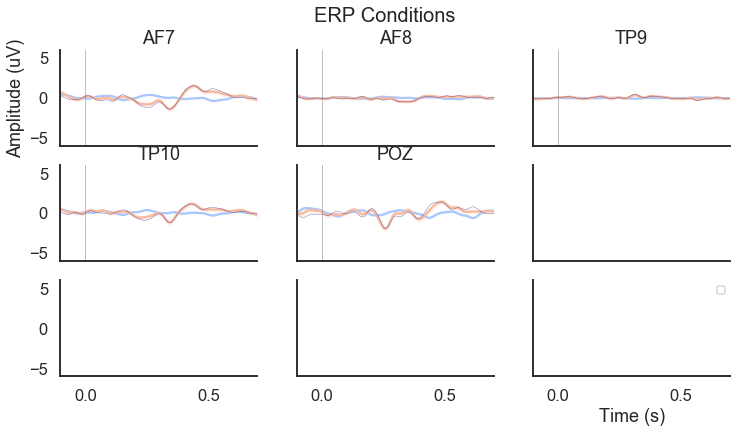

The best predictor is: Vect + RegLDA score:0.7534081284588879
training with 9 characters
device:muse2+ user:compmonks dir:session_000


c:\users\pierr\python354\lib\site-packages\pandas\core\indexes\base.py:2820: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  target = np.asarray(target)


Creating RawArray with float64 data, n_channels=6, n_times=87155
    Range : 0 ... 87154 =      0.000 ...   340.445 secs
Ready.
device:muse2+ user:compmonks dir:session_001
Creating RawArray with float64 data, n_channels=6, n_times=87206
    Range : 0 ... 87205 =      0.000 ...   340.645 secs
Ready.
device:muse2+ user:compmonks dir:session_002
Creating RawArray with float64 data, n_channels=6, n_times=87159
    Range : 0 ... 87158 =      0.000 ...   340.461 secs
Ready.
device:muse2+ user:compmonks dir:session_003
Creating RawArray with float64 data, n_channels=6, n_times=87151
    Range : 0 ... 87150 =      0.000 ...   340.430 secs
Ready.
device:muse2+ user:compmonks dir:session_004
Creating RawArray with float64 data, n_channels=6, n_times=87236
    Range : 0 ... 87235 =      0.000 ...   340.762 secs
Ready.
Effective window size : 8.000 (s)


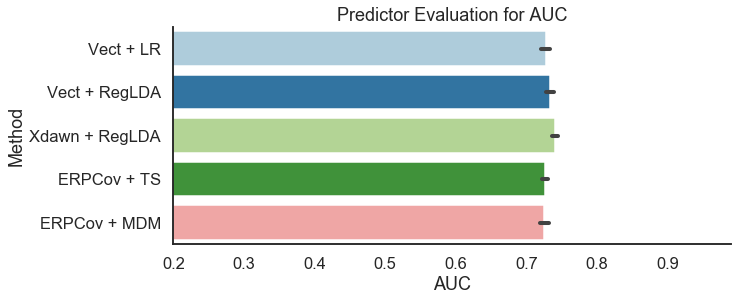

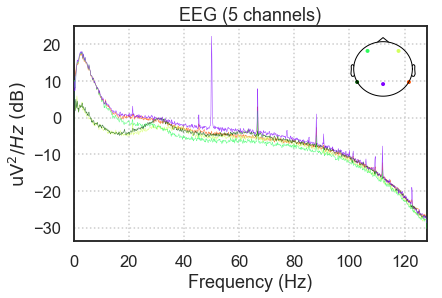

Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Effective window size : 8.000 (s)


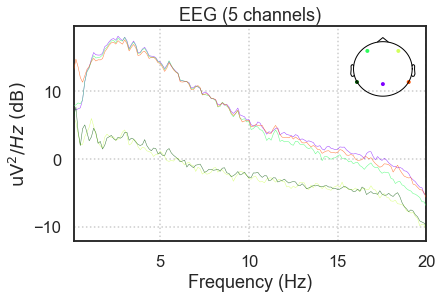

8093 events found
Event IDs: [1 2]
sample drop: 6.338811318423332 %


c:\users\pierr\python354\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


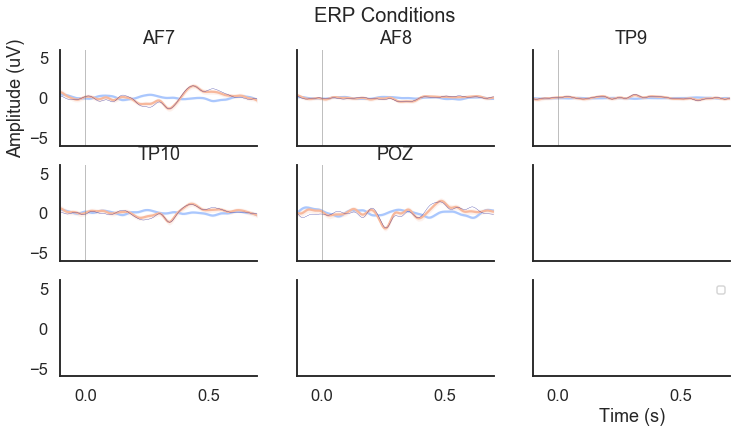

The best predictor is: Xdawn + RegLDA score:0.7369250157529931
training with 8 characters
device:muse2+ user:compmonks dir:session_000


c:\users\pierr\python354\lib\site-packages\pandas\core\indexes\base.py:2820: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  target = np.asarray(target)


Creating RawArray with float64 data, n_channels=6, n_times=77469
    Range : 0 ... 77468 =      0.000 ...   302.609 secs
Ready.
device:muse2+ user:compmonks dir:session_001
Creating RawArray with float64 data, n_channels=6, n_times=77520
    Range : 0 ... 77519 =      0.000 ...   302.809 secs
Ready.
device:muse2+ user:compmonks dir:session_002
Creating RawArray with float64 data, n_channels=6, n_times=77469
    Range : 0 ... 77468 =      0.000 ...   302.609 secs
Ready.
device:muse2+ user:compmonks dir:session_003
Creating RawArray with float64 data, n_channels=6, n_times=77465
    Range : 0 ... 77464 =      0.000 ...   302.594 secs
Ready.
device:muse2+ user:compmonks dir:session_004
Creating RawArray with float64 data, n_channels=6, n_times=77550
    Range : 0 ... 77549 =      0.000 ...   302.926 secs
Ready.
Effective window size : 8.000 (s)


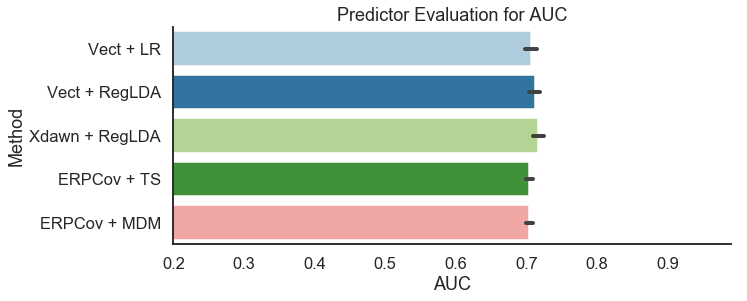

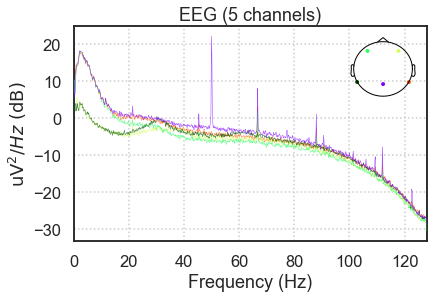

Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Effective window size : 8.000 (s)


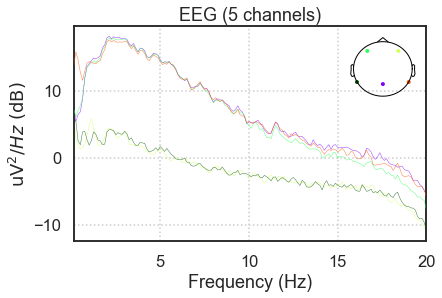

7193 events found
Event IDs: [1 2]
sample drop: 6.520227999443906 %


c:\users\pierr\python354\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


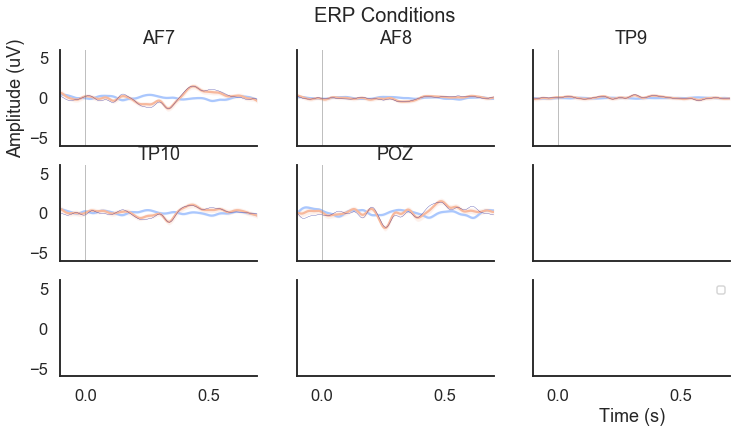

The best predictor is: Vect + RegLDA score:0.7568388505854462
training with 7 characters
device:muse2+ user:compmonks dir:session_000


c:\users\pierr\python354\lib\site-packages\pandas\core\indexes\base.py:2820: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  target = np.asarray(target)


Creating RawArray with float64 data, n_channels=6, n_times=67778
    Range : 0 ... 67777 =      0.000 ...   264.754 secs
Ready.
device:muse2+ user:compmonks dir:session_001
Creating RawArray with float64 data, n_channels=6, n_times=67778
    Range : 0 ... 67777 =      0.000 ...   264.754 secs
Ready.
device:muse2+ user:compmonks dir:session_002
Creating RawArray with float64 data, n_channels=6, n_times=67782
    Range : 0 ... 67781 =      0.000 ...   264.770 secs
Ready.
device:muse2+ user:compmonks dir:session_003
Creating RawArray with float64 data, n_channels=6, n_times=67774
    Range : 0 ... 67773 =      0.000 ...   264.738 secs
Ready.
device:muse2+ user:compmonks dir:session_004
Creating RawArray with float64 data, n_channels=6, n_times=67860
    Range : 0 ... 67859 =      0.000 ...   265.074 secs
Ready.
Effective window size : 8.000 (s)


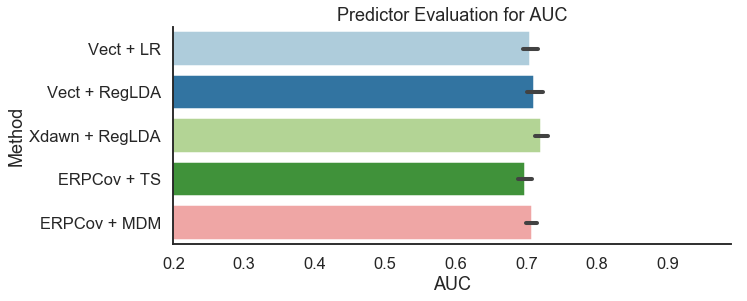

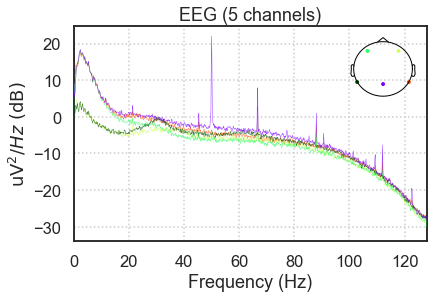

Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Effective window size : 8.000 (s)


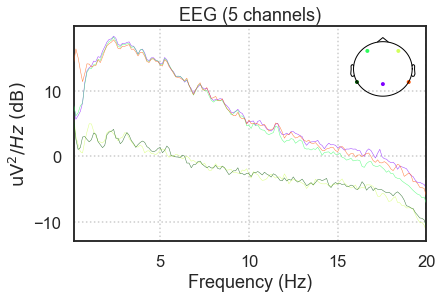

6293 events found
Event IDs: [1 2]
sample drop: 6.70586365803274 %


c:\users\pierr\python354\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


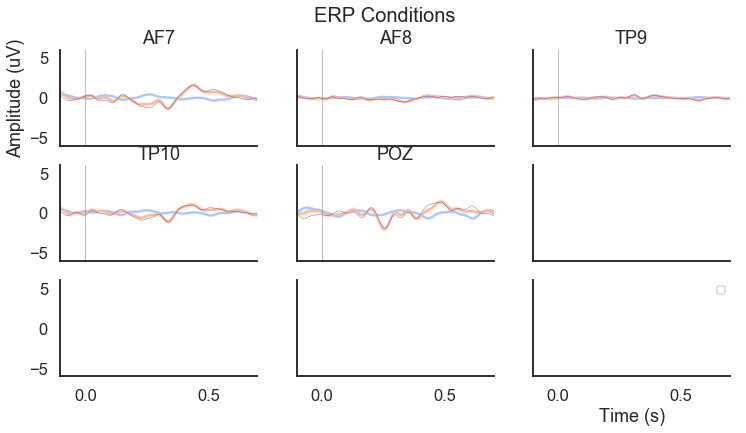

The best predictor is: Xdawn + RegLDA score:0.7374468476258891
training with 6 characters
device:muse2+ user:compmonks dir:session_000


c:\users\pierr\python354\lib\site-packages\pandas\core\indexes\base.py:2820: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  target = np.asarray(target)


Creating RawArray with float64 data, n_channels=6, n_times=58092
    Range : 0 ... 58091 =      0.000 ...   226.918 secs
Ready.
device:muse2+ user:compmonks dir:session_001
Creating RawArray with float64 data, n_channels=6, n_times=58088
    Range : 0 ... 58087 =      0.000 ...   226.902 secs
Ready.
device:muse2+ user:compmonks dir:session_002
Creating RawArray with float64 data, n_channels=6, n_times=58092
    Range : 0 ... 58091 =      0.000 ...   226.918 secs
Ready.
device:muse2+ user:compmonks dir:session_003
Creating RawArray with float64 data, n_channels=6, n_times=58084
    Range : 0 ... 58083 =      0.000 ...   226.887 secs
Ready.
device:muse2+ user:compmonks dir:session_004
Creating RawArray with float64 data, n_channels=6, n_times=58173
    Range : 0 ... 58172 =      0.000 ...   227.234 secs
Ready.
Effective window size : 8.000 (s)


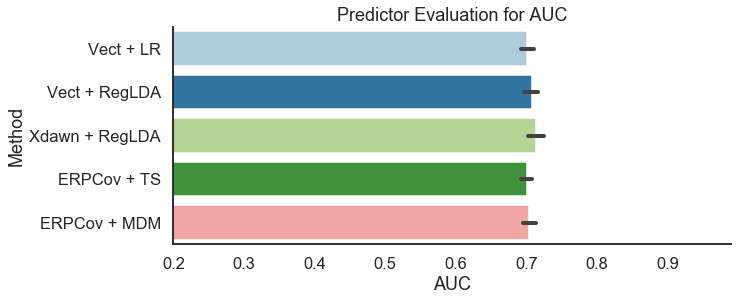

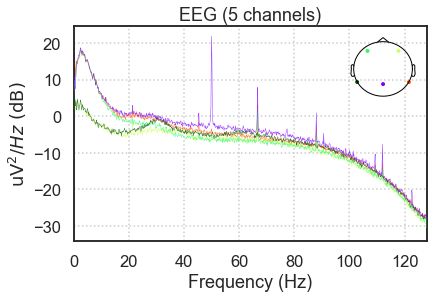

Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Effective window size : 8.000 (s)


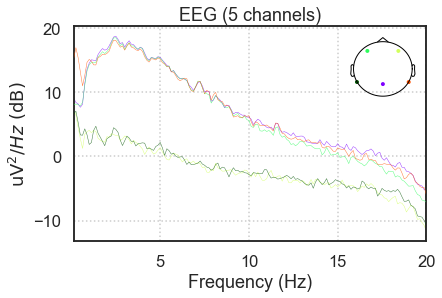

5393 events found
Event IDs: [1 2]
sample drop: 6.823660300389389 %


c:\users\pierr\python354\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


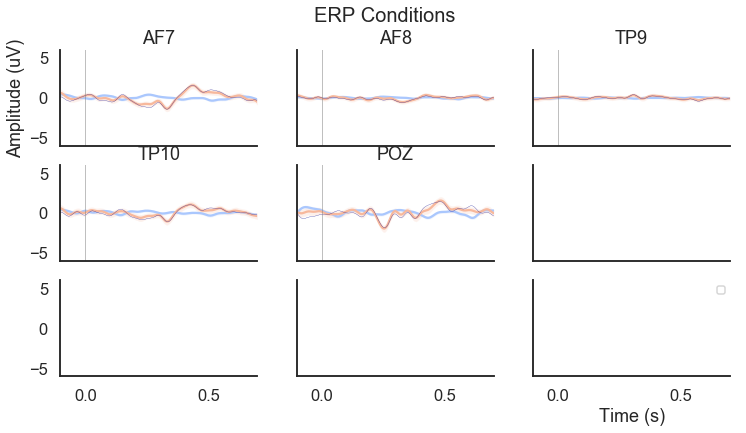

The best predictor is: ERPCov + MDM score:0.7359691264920023
training with 5 characters
device:muse2+ user:compmonks dir:session_000


c:\users\pierr\python354\lib\site-packages\pandas\core\indexes\base.py:2820: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  target = np.asarray(target)


Creating RawArray with float64 data, n_channels=6, n_times=48401
    Range : 0 ... 48400 =      0.000 ...   189.062 secs
Ready.
device:muse2+ user:compmonks dir:session_001
Creating RawArray with float64 data, n_channels=6, n_times=48402
    Range : 0 ... 48401 =      0.000 ...   189.066 secs
Ready.
device:muse2+ user:compmonks dir:session_002
Creating RawArray with float64 data, n_channels=6, n_times=48402
    Range : 0 ... 48401 =      0.000 ...   189.066 secs
Ready.
device:muse2+ user:compmonks dir:session_003
Creating RawArray with float64 data, n_channels=6, n_times=48398
    Range : 0 ... 48397 =      0.000 ...   189.051 secs
Ready.
device:muse2+ user:compmonks dir:session_004
Creating RawArray with float64 data, n_channels=6, n_times=48487
    Range : 0 ... 48486 =      0.000 ...   189.398 secs
Ready.
Effective window size : 8.000 (s)


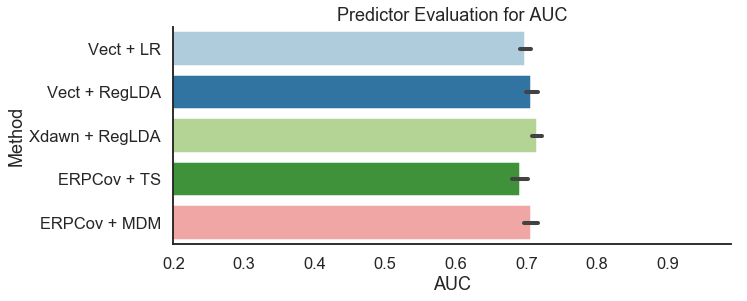

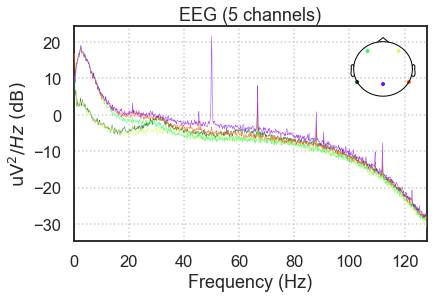

Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Effective window size : 8.000 (s)


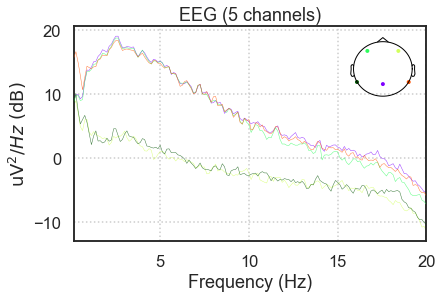

4493 events found
Event IDs: [1 2]
sample drop: 7.166703761406634 %


c:\users\pierr\python354\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


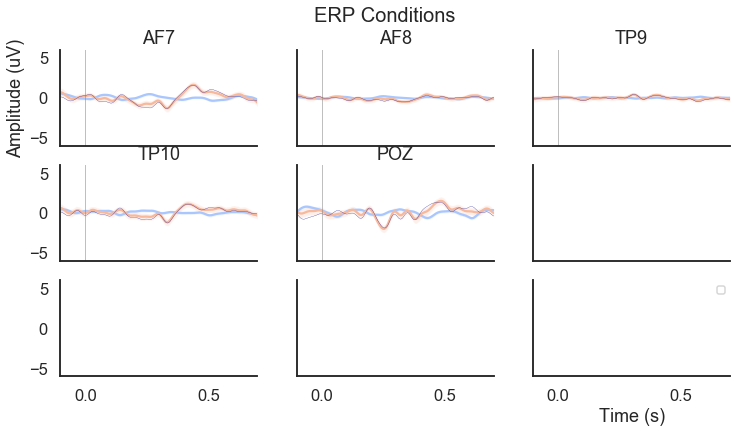

The best predictor is: Vect + RegLDA score:0.7615262751682397
training with 4 characters
device:muse2+ user:compmonks dir:session_000


c:\users\pierr\python354\lib\site-packages\pandas\core\indexes\base.py:2820: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  target = np.asarray(target)


Creating RawArray with float64 data, n_channels=6, n_times=38711
    Range : 0 ... 38710 =      0.000 ...   151.211 secs
Ready.
device:muse2+ user:compmonks dir:session_001
Creating RawArray with float64 data, n_channels=6, n_times=38711
    Range : 0 ... 38710 =      0.000 ...   151.211 secs
Ready.
device:muse2+ user:compmonks dir:session_002
Creating RawArray with float64 data, n_channels=6, n_times=38711
    Range : 0 ... 38710 =      0.000 ...   151.211 secs
Ready.
device:muse2+ user:compmonks dir:session_003
Creating RawArray with float64 data, n_channels=6, n_times=38707
    Range : 0 ... 38706 =      0.000 ...   151.195 secs
Ready.
device:muse2+ user:compmonks dir:session_004
Creating RawArray with float64 data, n_channels=6, n_times=38801
    Range : 0 ... 38800 =      0.000 ...   151.562 secs
Ready.
Effective window size : 8.000 (s)


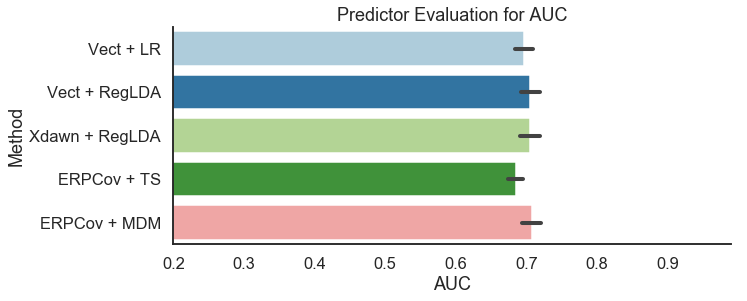

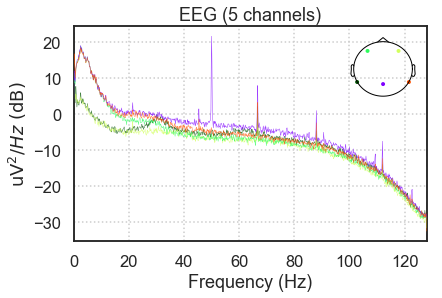

Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Effective window size : 8.000 (s)


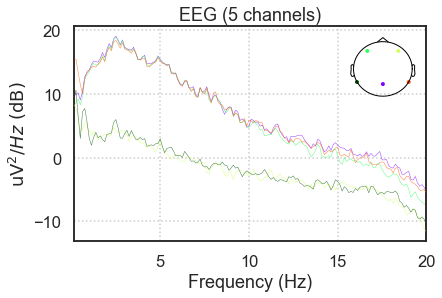

3593 events found
Event IDs: [1 2]
sample drop: 7.51461174505984 %


c:\users\pierr\python354\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


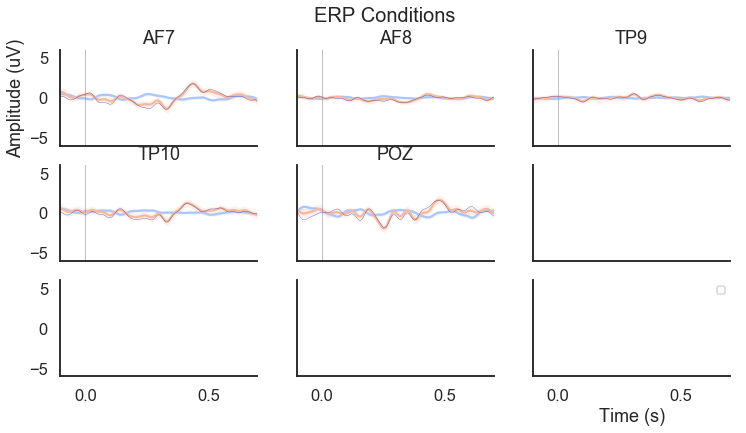

The best predictor is: ERPCov + MDM score:0.7548531289910599
training with 3 characters
device:muse2+ user:compmonks dir:session_000


c:\users\pierr\python354\lib\site-packages\pandas\core\indexes\base.py:2820: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  target = np.asarray(target)


Creating RawArray with float64 data, n_channels=6, n_times=29025
    Range : 0 ... 29024 =      0.000 ...   113.375 secs
Ready.
device:muse2+ user:compmonks dir:session_001
Creating RawArray with float64 data, n_channels=6, n_times=29025
    Range : 0 ... 29024 =      0.000 ...   113.375 secs
Ready.
device:muse2+ user:compmonks dir:session_002
Creating RawArray with float64 data, n_channels=6, n_times=29025
    Range : 0 ... 29024 =      0.000 ...   113.375 secs
Ready.
device:muse2+ user:compmonks dir:session_003
Creating RawArray with float64 data, n_channels=6, n_times=29021
    Range : 0 ... 29020 =      0.000 ...   113.359 secs
Ready.
device:muse2+ user:compmonks dir:session_004
Creating RawArray with float64 data, n_channels=6, n_times=29110
    Range : 0 ... 29109 =      0.000 ...   113.707 secs
Ready.
Effective window size : 8.000 (s)


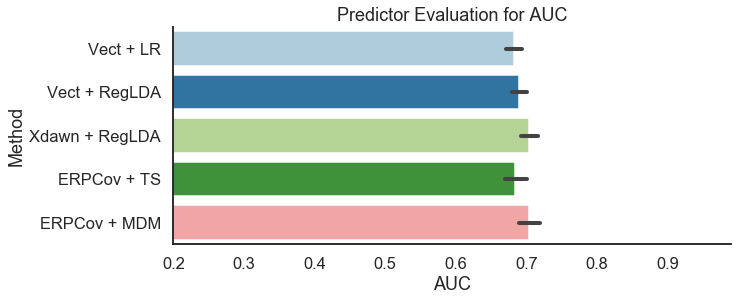

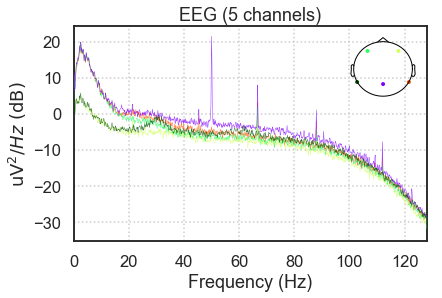

Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Effective window size : 8.000 (s)


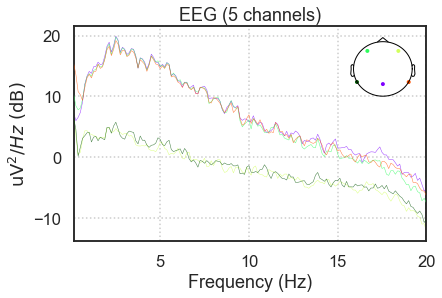

2693 events found
Event IDs: [1 2]
sample drop: 8.057927961381361 %


c:\users\pierr\python354\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


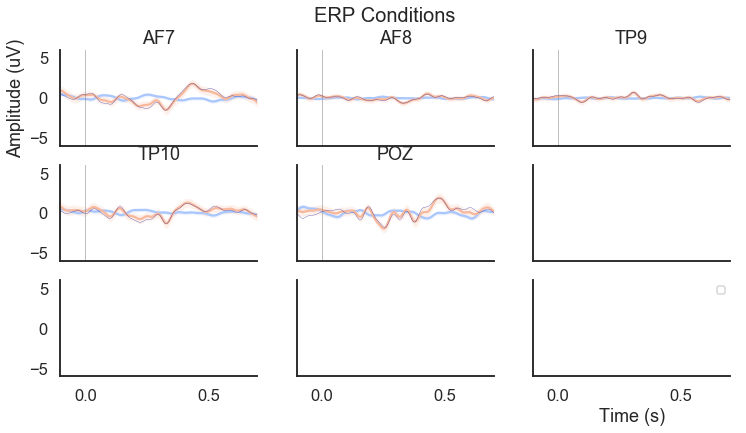

The best predictor is: Xdawn + RegLDA score:0.7654527938342968
training with 2 characters
device:muse2+ user:compmonks dir:session_000


c:\users\pierr\python354\lib\site-packages\pandas\core\indexes\base.py:2820: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  target = np.asarray(target)


Creating RawArray with float64 data, n_channels=6, n_times=19334
    Range : 0 ... 19333 =      0.000 ...    75.520 secs
Ready.
device:muse2+ user:compmonks dir:session_001
Creating RawArray with float64 data, n_channels=6, n_times=19334
    Range : 0 ... 19333 =      0.000 ...    75.520 secs
Ready.
device:muse2+ user:compmonks dir:session_002
Creating RawArray with float64 data, n_channels=6, n_times=19335
    Range : 0 ... 19334 =      0.000 ...    75.523 secs
Ready.
device:muse2+ user:compmonks dir:session_003
Creating RawArray with float64 data, n_channels=6, n_times=19331
    Range : 0 ... 19330 =      0.000 ...    75.508 secs
Ready.
device:muse2+ user:compmonks dir:session_004
Creating RawArray with float64 data, n_channels=6, n_times=19420
    Range : 0 ... 19419 =      0.000 ...    75.855 secs
Ready.
Effective window size : 8.000 (s)


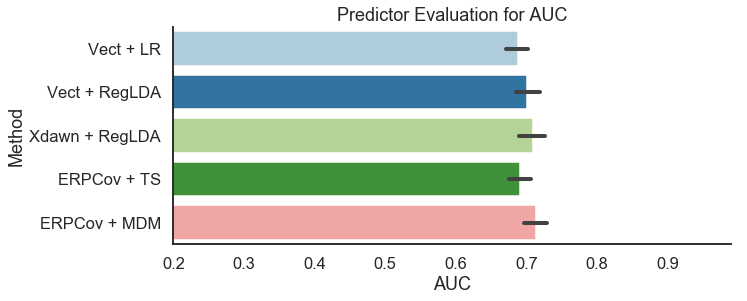

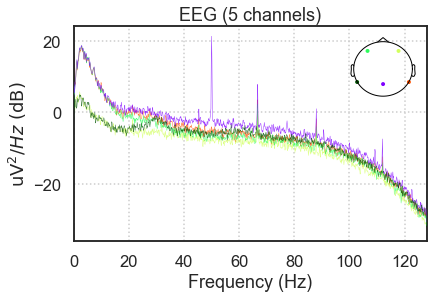

Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Effective window size : 8.000 (s)


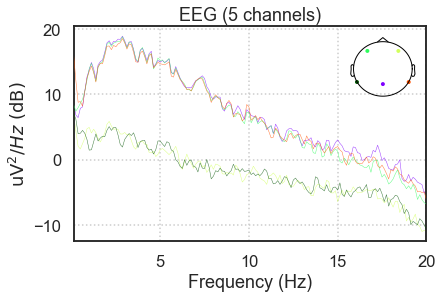

1793 events found
Event IDs: [1 2]
sample drop: 9.146681539319578 %


c:\users\pierr\python354\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


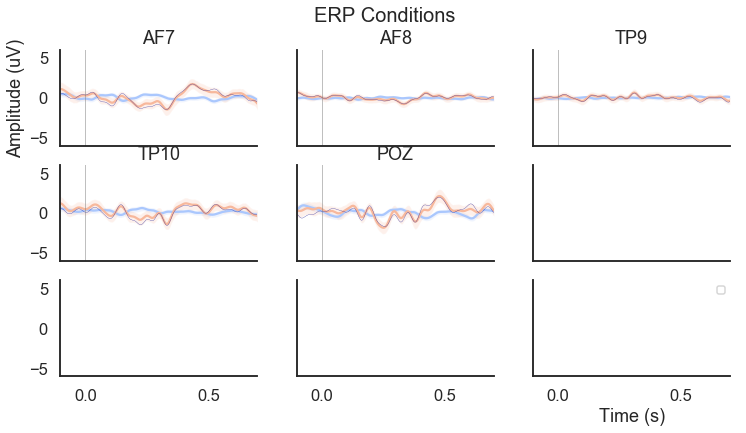

The best predictor is: Vect + RegLDA score:0.7832697914330568
training with 1 characters
device:muse2+ user:compmonks dir:session_000


c:\users\pierr\python354\lib\site-packages\pandas\core\indexes\base.py:2820: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  target = np.asarray(target)


Creating RawArray with float64 data, n_channels=6, n_times=9644
    Range : 0 ... 9643 =      0.000 ...    37.668 secs
Ready.
device:muse2+ user:compmonks dir:session_001
Creating RawArray with float64 data, n_channels=6, n_times=9644
    Range : 0 ... 9643 =      0.000 ...    37.668 secs
Ready.
device:muse2+ user:compmonks dir:session_002
Creating RawArray with float64 data, n_channels=6, n_times=9644
    Range : 0 ... 9643 =      0.000 ...    37.668 secs
Ready.
device:muse2+ user:compmonks dir:session_003
Creating RawArray with float64 data, n_channels=6, n_times=9644
    Range : 0 ... 9643 =      0.000 ...    37.668 secs
Ready.
device:muse2+ user:compmonks dir:session_004
Creating RawArray with float64 data, n_channels=6, n_times=9644
    Range : 0 ... 9643 =      0.000 ...    37.668 secs
Ready.
Effective window size : 8.000 (s)


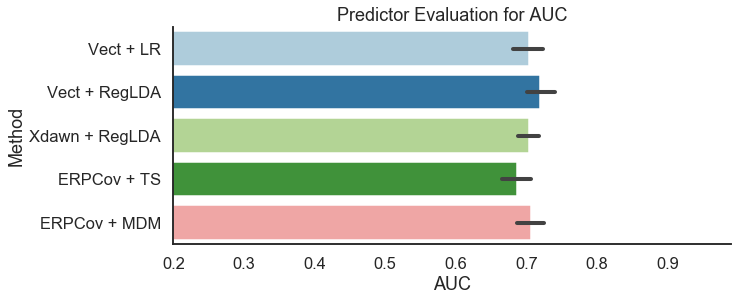

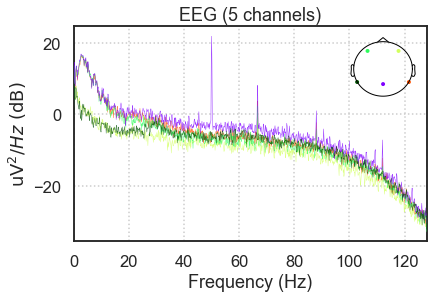

Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Effective window size : 8.000 (s)


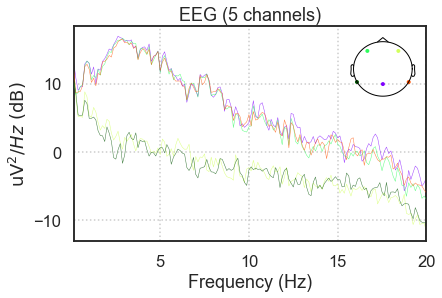

895 events found
Event IDs: [1 2]
sample drop: 10.167597765363123 %


c:\users\pierr\python354\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


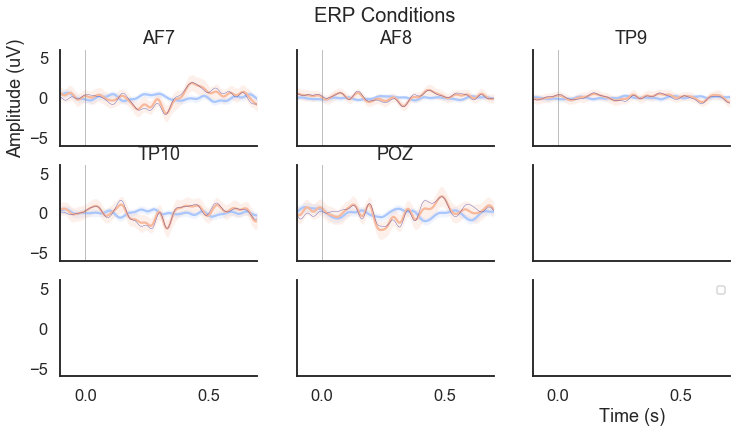

The best predictor is: ERPCov + MDM score:0.7895710059171597


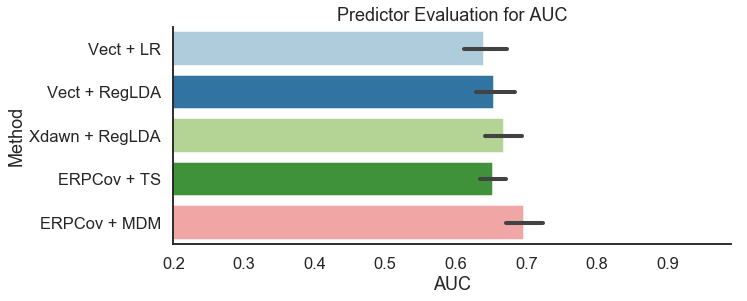

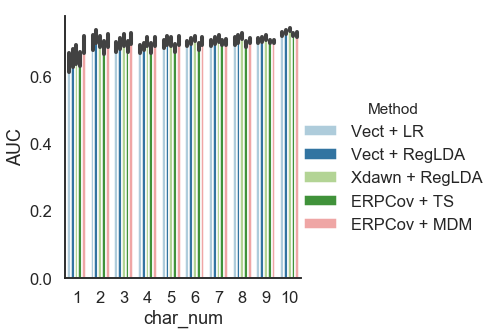

In [5]:

all_results =  pd.DataFrame({'Temp' : []})
the_data_path = os.path.join(the_folder_path,the_device,the_user) if the_user != "all" else os.path.join(the_folder_path,the_device)

# evaluate while decreasing the number of characters used
for wl in range(char_num,0,-1):
    raw = []
    print("training with {} characters".format(wl))
    # loop through subdirs and concatenate data
    for root, subdirs, files in os.walk(the_data_path):
        for dirs in subdirs:
            print("device:{} user:{} dir:{}".format(the_device,the_user,dirs))
            file_list = os.listdir(os.path.join(root,dirs))
            if len(file_list) == 2:
                if "FEEDBACK" in file_list[0]:
                    dataF = pd.read_hdf(os.path.join(root,dirs,file_list[0]),'data')
                    dataA = pd.read_hdf(os.path.join(root,dirs,file_list[1]),'EEG')
                else:
                    dataF = pd.read_hdf(os.path.join(root,dirs,file_list[1]),'data')
                    dataA = pd.read_hdf(os.path.join(root,dirs,file_list[0]),'EEG')
                #
                if wl != char_num:
                    #get a chunk of the data depending of the number of charactersw to use
                    chunks_indexes = segmentByLengthSeq(dataF['index'],12.0,1000)
                    #trim signal accordingly
                    stop_F = dataF.index[chunks_indexes[wl][2]]
                    stop_A = dataA.index.get_loc(stop_F,method='ffill')
                    dataA = dataA.iloc[:stop_A]
                    #
                dataA['Stim'] = np.nan
                prev_marker = 0
                for index,row in dataA.iterrows():
                    if prev_marker == 0:
                        row['Stim'] = dataF.iloc[dataF.index.get_loc(pd.to_datetime(index),method='nearest')]['marker']
                    else:
                        row['Stim'] = 0
                        prev_marker = dataF.iloc[dataF.index.get_loc(pd.to_datetime(index),method='nearest')]['marker'].astype(int)
                channel_names = list(dataA.keys())
                channel_types = ['eeg'] * (len(list(dataA.keys()))-1) + ['stim']
                the_data = dataA.values[:].T
                the_data[:-1] *= 1e-6 if the_units == "uVolts" else 1
                info = create_info(ch_names = channel_names, 
                                   ch_types = channel_types,
                                   sfreq = the_freq, 
                                   montage = the_montage)
                raw.append(RawArray(data = the_data, info = info))
                #
    the_raw = concatenate_raws(raw)
    # plot PSD on raw data
    the_raw.plot_psd()
    # bandpass filter
    the_raw=the_raw.filter(.1,20, method='iir',iir_params = dict(order=8,ftype='butter',output='sos'))
    # plot PSD on filtered data
    the_raw.plot_psd(fmin=.1, fmax=20)
    # events with artifact rejection
    the_events = find_events(the_raw)
    the_epochs = Epochs(the_raw,
                        events = the_events, 
                        event_id = the_markers,
                        tmin = -0.1, tmax = 0.7, # tmin and tmax are in s. ie. 100ms before and 800ms after
                        baseline = None, # no baseline correction necessary after bandpass
                        reject = {'eeg': 75e-6}, # remove amplitudes above 75uV ie. eye blinks
                        preload = True,
                        verbose = False,
                        picks = list(range(len(channel_names)-1))
                       )
    the_sample_drop = (1 - len(the_epochs.events)/len(the_events)) * 100
    print("sample drop: {} %".format(the_sample_drop))
    # plot events conditions
    conditions = OrderedDict()
    conditions['2: Non-target'] = [the_markers["Non-Target"]]
    conditions['1: Target'] = [the_markers["Target"]]
    if len(the_epochs.events)>0:
        plotConditions(the_epochs, the_units, len(channel_names)-1, diff_waveform = (2,1) ,conditions = conditions)
    else:
        print("")
        print("---> dataset too noisy to find any events")
    # prepare data for training
    the_epochs.pick_types(eeg=True)
    X = the_epochs.get_data() * 1e6
    times = the_epochs.times
    y = the_epochs.events[:, -1]
    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=42)
    auc = []
    methods = []
    # cross validation AUC score by classifier
    for m in clfs:
        res = cross_val_score(clfs[m], X, y==2, scoring='roc_auc', cv=cv, n_jobs=-1)
        auc.extend(res)
        methods.extend([m]*len(res))
    # plot
    results = pd.DataFrame(data=auc, columns=['AUC'])
    results['Method'] = methods
    results['char_num'] = wl
    palette = sns.color_palette(categorical_color_palette, len(results))
    plt.figure(figsize=[10,4])
    plt.title('Predictor Evaluation for AUC')
    sns.barplot(data=results, x='AUC', y='Method', palette=palette)
    plt.xlim(0.2, 0.99)
    sns.despine()
    #
    the_best_score = max(auc)
    the_best_method = methods[auc.index(the_best_score)]
    print("The best predictor is: {} score:{}".format(the_best_method, the_best_score))
    # concatenating all results
    if all_results.empty:
        all_results = results.copy()
    else:
        all_results = pd.concat([all_results, results], ignore_index=True, sort=False)
# plotting the accuracy comparison over characters amount
sns.catplot(x='char_num', y='AUC', hue='Method', data=all_results, kind='bar',palette=palette)

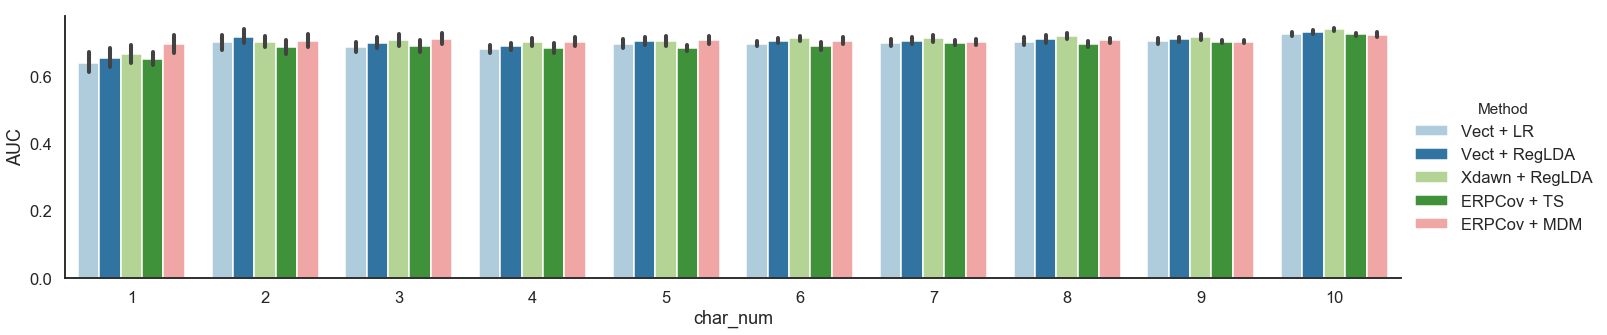

In [7]:
sns.catplot(x='char_num', y='AUC', hue='Method', data=all_results, kind='bar',palette=palette,aspect=4)